In [1]:
!git clone https://github.com/sanepunk/ViT.git

Cloning into 'ViT'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 25 (delta 5), reused 24 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 11.30 KiB | 11.30 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from models import ViT
import sys
import numpy as np
from sklearn.metrics import accuracy_score
torch.set_num_threads(4)
model = ViT(
            image_size= 224,
			in_channels= 3,
			patch_size= 16,
			num_transformer_layers= 10,
			embedding_dim= 256,
			mlp_size= 3072,
			num_heads= 8,
			attention_dropout = 0.,
			mlp_dropout = 0.1,
			embedding_dropout = 0.1,
			num_classes= 10
)
# try:
#     model.load_state_dict(torch.load('model_interrupted.pth'))
# except:
#     print("Model not available")
model = model.to('cuda')
train_accs = []
test_accs = []
train_losses = []
test_losses = []
def handle_interrupt():
    print("\nTraining interrupted by user (Ctrl+C). Performing cleanup...")
    # Place any custom code here, like saving model, logging, etc.
    # For example, you could save the model state:
    torch.save(model.state_dict(), "model_interrupted.pth")
    np.savez('training_results.npz', train_accs, test_accs, train_losses, test_losses)
    print("Model state saved.")
    sys.exit(0)  # Exit the program gracefully




transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256 (standard ImageNet preprocessing)
    # transforms.CenterCrop(224),  # Crop the center to 224x224 (standard ImageNet size)
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

trainset = torchvision.datasets.Imagenette(root='./data', split = "train", download=False, transform=transform)
testset = torchvision.datasets.Imagenette(root='./data', split='val', download=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


try:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        train_bar = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training', ncols=100)

        for batch_idx, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())
            # print("\nFirst 10 train labels:", list(all_train_labels[:10]))
            # print("\nFirst 10 train predictions:", list(all_train_preds[:10]))

            running_loss += loss.item()
            train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), acc=train_accuracy)

            # Print training stats every 100 batches
            # if (batch_idx + 1) % 100 == 0:
            #     print(f'Batch [{batch_idx + 1}/{len(trainloader)}] - Loss: {running_loss / (batch_idx + 1):.4f} - Accuracy: {train_accuracy:.2f}%')

        # Save training loss and accuracy for each epoch
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = accuracy_score(all_train_labels, all_train_preds) * 100
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        all_test_labels = []
        all_test_preds = []
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted.cpu().numpy())

        epoch_test_loss = running_test_loss / len(testloader)
        epoch_test_acc = accuracy_score(all_test_labels, all_test_preds) * 100
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Loss: {epoch_test_loss:.4f} - Test Accuracy: {epoch_test_acc:.2f}%')

    print("\nTraining completed!")
    print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")

except KeyboardInterrupt:
    handle_interrupt()

Epoch 1/10 - Training: 100%|███████████████████| 74/74 [01:53<00:00,  1.54s/it, acc=19.9, loss=2.24]


Epoch [1/10] - Train Loss: 2.2353 - Train Accuracy: 19.88%
Epoch [1/10] - Test Loss: 2.1057 - Test Accuracy: 24.00%


Epoch 2/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/10 - Training: 100%|███████████████████| 74/74 [01:49<00:00,  1.48s/it, acc=29.4, loss=1.99]


Epoch [2/10] - Train Loss: 1.9884 - Train Accuracy: 29.36%
Epoch [2/10] - Test Loss: 1.8921 - Test Accuracy: 34.11%


Epoch 3/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/10 - Training: 100%|███████████████████| 74/74 [01:48<00:00,  1.47s/it, acc=38.3, loss=1.79]


Epoch [3/10] - Train Loss: 1.7882 - Train Accuracy: 38.27%
Epoch [3/10] - Test Loss: 1.7469 - Test Accuracy: 40.82%


Epoch 4/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/10 - Training: 100%|███████████████████| 74/74 [01:49<00:00,  1.48s/it, acc=44.3, loss=1.62]


Epoch [4/10] - Train Loss: 1.6196 - Train Accuracy: 44.28%
Epoch [4/10] - Test Loss: 1.7023 - Test Accuracy: 41.83%


Epoch 5/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/10 - Training: 100%|████████████████████| 74/74 [01:51<00:00,  1.51s/it, acc=48.6, loss=1.5]


Epoch [5/10] - Train Loss: 1.5035 - Train Accuracy: 48.61%
Epoch [5/10] - Test Loss: 1.5021 - Test Accuracy: 48.54%


Epoch 6/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/10 - Training: 100%|███████████████████| 74/74 [01:49<00:00,  1.48s/it, acc=51.8, loss=1.41]


Epoch [6/10] - Train Loss: 1.4111 - Train Accuracy: 51.84%
Epoch [6/10] - Test Loss: 1.4593 - Test Accuracy: 51.11%


Epoch 7/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/10 - Training: 100%|███████████████████| 74/74 [01:49<00:00,  1.48s/it, acc=54.9, loss=1.33]


Epoch [7/10] - Train Loss: 1.3348 - Train Accuracy: 54.95%
Epoch [7/10] - Test Loss: 1.4093 - Test Accuracy: 53.02%


Epoch 8/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/10 - Training: 100%|███████████████████| 74/74 [01:48<00:00,  1.46s/it, acc=57.3, loss=1.25]


Epoch [8/10] - Train Loss: 1.2528 - Train Accuracy: 57.32%
Epoch [8/10] - Test Loss: 1.3451 - Test Accuracy: 54.37%


Epoch 9/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/10 - Training: 100%|███████████████████| 74/74 [01:50<00:00,  1.49s/it, acc=58.6, loss=1.22]


Epoch [9/10] - Train Loss: 1.2237 - Train Accuracy: 58.60%
Epoch [9/10] - Test Loss: 1.2813 - Test Accuracy: 58.06%


Epoch 10/10 - Training:   0%|                                                | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/10 - Training: 100%|██████████████████| 74/74 [01:52<00:00,  1.52s/it, acc=61.1, loss=1.15]


Epoch [10/10] - Train Loss: 1.1482 - Train Accuracy: 61.15%
Epoch [10/10] - Test Loss: 1.3028 - Test Accuracy: 56.84%

Training completed!
Final Training Accuracy: 61.15%
Final Test Accuracy: 56.84%


In [10]:
torch.save(model.state_dict(), "model_interrupted.pth")
np.savez('training_results.npz', train_accs, test_accs, train_losses, test_losses)

In [26]:
try:
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        train_bar = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training', ncols=100)

        for batch_idx, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())
            # print("\nFirst 10 train labels:", list(all_train_labels[:10]))
            # print("\nFirst 10 train predictions:", list(all_train_preds[:10]))

            running_loss += loss.item()
            train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), acc=train_accuracy)

            # Print training stats every 100 batches
            # if (batch_idx + 1) % 100 == 0:
            #     print(f'Batch [{batch_idx + 1}/{len(trainloader)}] - Loss: {running_loss / (batch_idx + 1):.4f} - Accuracy: {train_accuracy:.2f}%')

        # Save training loss and accuracy for each epoch
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = accuracy_score(all_train_labels, all_train_preds) * 100
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        all_test_labels = []
        all_test_preds = []
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted.cpu().numpy())

        epoch_test_loss = running_test_loss / len(testloader)
        epoch_test_acc = accuracy_score(all_test_labels, all_test_preds) * 100
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Loss: {epoch_test_loss:.4f} - Test Accuracy: {epoch_test_acc:.2f}%')

    print("\nTraining completed!")
    print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")

except KeyboardInterrupt:
    handle_interrupt()

torch.save(model.state_dict(), "model_interrupted.pth")
np.savez('training_results.npz', train_accs, test_accs, train_losses, test_losses)

Epoch 1/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10 - Training: 100%|██████████████████| 74/74 [01:51<00:00,  1.50s/it, acc=71.2, loss=0.863]


Epoch [1/10] - Train Loss: 0.8628 - Train Accuracy: 71.21%
Epoch [1/10] - Test Loss: 1.2966 - Test Accuracy: 59.62%


Epoch 2/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/10 - Training: 100%|██████████████████| 74/74 [01:49<00:00,  1.48s/it, acc=71.4, loss=0.849]


Epoch [2/10] - Train Loss: 0.8486 - Train Accuracy: 71.40%
Epoch [2/10] - Test Loss: 1.2202 - Test Accuracy: 61.81%


Epoch 3/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/10 - Training: 100%|████████████████████| 74/74 [01:49<00:00,  1.48s/it, acc=73.2, loss=0.8]


Epoch [3/10] - Train Loss: 0.7996 - Train Accuracy: 73.21%
Epoch [3/10] - Test Loss: 1.2115 - Test Accuracy: 61.38%


Epoch 4/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/10 - Training: 100%|████████████████████| 74/74 [01:48<00:00,  1.47s/it, acc=72.8, loss=0.8]


Epoch [4/10] - Train Loss: 0.7996 - Train Accuracy: 72.84%
Epoch [4/10] - Test Loss: 1.2849 - Test Accuracy: 59.67%


Epoch 5/10 - Training:   0%|                                                 | 0/74 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/10 - Training: 100%|██████████████████| 74/74 [01:48<00:00,  1.47s/it, acc=73.7, loss=0.766]


Epoch [5/10] - Train Loss: 0.7660 - Train Accuracy: 73.68%
Epoch [5/10] - Test Loss: 1.2043 - Test Accuracy: 62.19%

Training completed!
Final Training Accuracy: 73.68%
Final Test Accuracy: 62.19%


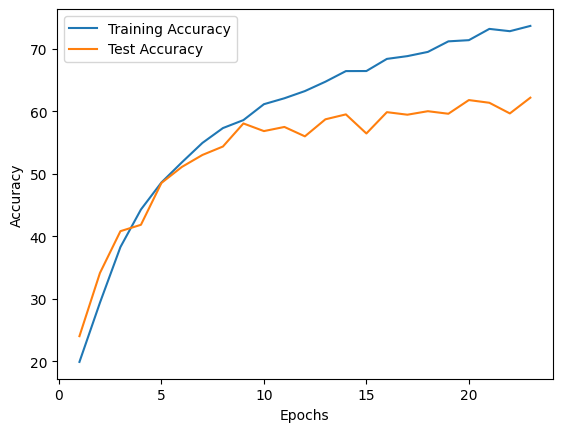

In [31]:
epochs = np.arange(1, num_epochs+14)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

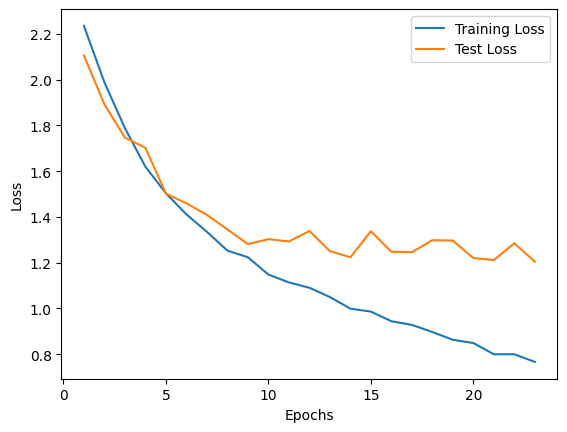

In [32]:
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()